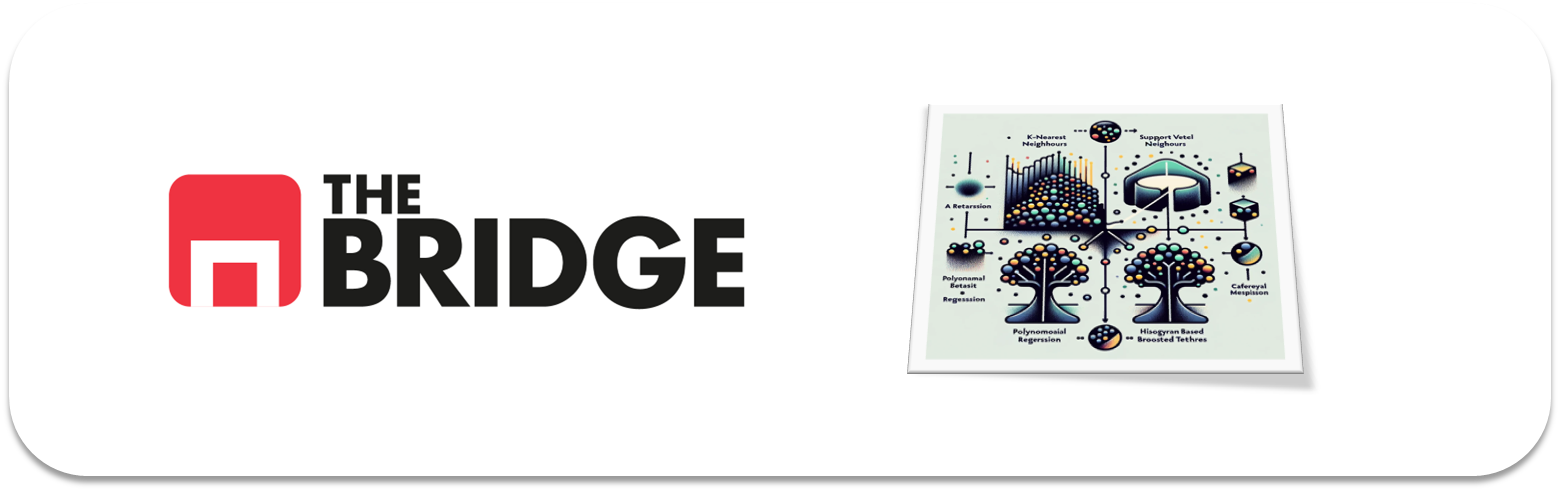

## PRACTICA OBLIGATORIA: **Repaso Aprendizaje Supervisado**

* La práctica obligatoria de esta unidad consiste en resolver sobre un mismo dataset un problema de clasificación y un problema de regresión. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [28]:
# Importar las librerías necesarias


import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    roc_curve, 
    auc, 
    mean_absolute_error, 
    mean_absolute_percentage_error, 
    r2_score
)

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from collections import Counter


### #1 Explicación del dataset y carga de datos

Vamos a trabajar con el dataset "Wine Quality", que es un dataset en el que se recogen diversas características fisicoquímicas de las variades tinta y blanca del "Vinho verde" portugués. Las variables del dataset se describen a continuación


1. **Acidez fija**: La mayoría de los ácidos involucrados con el vino son fijos o no volátiles (no se evaporan fácilmente).
2. **Acidez volátil**: La cantidad de ácido acético en el vino, que en niveles demasiado altos puede llevar a un sabor desagradable a vinagre.
3. **Ácido cítrico**: Encontrado en pequeñas cantidades, el ácido cítrico puede añadir 'frescura' y sabor a los vinos.
4. **Azúcar residual**: Es la cantidad de azúcar restante después de que se detiene la fermentación, es raro encontrar vinos con menos de 1 gramo/litro y vinos con más de 45 gramos/litro se consideran dulces.
5. **Cloruros**: La cantidad de sal en el vino.
6. **Dióxido de azufre libre**: La porción libre de SO2 existe en equilibrio entre el SO2 molecular (como un gas disuelto) y el ion bisulfito; previene el crecimiento microbiano y la oxidación del vino.
7. **Dióxido de azufre total**: Es la cantidad de formas libres y ligadas de S02; en bajas concentraciones, el SO2 es en su mayoría indetectable en el vino, pero en concentraciones libres de más de 50 ppm, el SO2 se hace evidente en la nariz y el sabor del vino.
8. **Densidad**: La densidad del vino es cercana a la del agua dependiendo del porcentaje de alcohol y contenido de azúcar.
9. **pH**: Describe qué tan ácido o básico es un vino en una escala de 0 (muy ácido) a 14 (muy básico); la mayoría de los vinos están entre 3-4 en la escala de pH.
10. **Sulfatos**: Un aditivo del vino que puede contribuir a los niveles de dióxido de azufre (SO2), que actúa como un antimicrobiano y antioxidante.
11. **Alcohol**: El porcentaje de contenido de alcohol del vino.
12. **Calidad**: Una variable de salida (basada en datos sensoriales, puntuación entre 0 y 10).
13. **Class**: Si es blanco o tinto.



Carga el dataset "wines_dataset.csv", muestra sus primeras filas, su información general y define dos variables target una para clasificación que permita predecir la calidad del vino según el resto de propiedas y otra variable target para regresión que permita predecir el grado alcohólico del vino a partir del resto de propiedades. 

El **objetivo de negocio en el primer problema** será anticipar la posible clasificación de sus vinos por los catadores profesionales y a partir de ahí poder planificar la producción, distribución y precio a poner a cada vino. En este sentido, el "cliente" nos dice que le gustaría poder clasificar correctamente lo mejor posible en media  (que interpretamos como el mejor recall medio posible).

El **objetivo de negocio en el segundo problema** (bastante artificial) es poder hacer simulaciones de posibles vinos futuros para saber cómo conseguir variedades más o menos alcohólicas para atender mercados diferentes. En este sentido, les interesa equivocarse lo menos posible porcentualmente sobre el grado alochólico real.

Muestra la distribución de ambos targets y haz un pequeño assesment previo de cada problema. NOTA: El dataset está limpio y sin valores faltantes.

In [29]:
# Cargar el dataset 'Wine Quality'
# Este dataset contiene características fisicoquímicas y datos de calidad de vinos tintos y blancos
file_path =  r'C:\Users\alber\OneDrive\Documentos\GitHub\DS_ONLINE_THEBRIDGE_ATC\04_Machine_Learning\Sprint_12\Unidad_02\Practica_Obligatoria\data\wines_dataset.csv'
wines = pd.read_csv(file_path, sep='|')  # Utilizamos el separador correcto para cargar los datos

In [30]:
# Mostrar las primeras filas del dataset
print("Primeras filas del dataset:")
print(wines.head())

# Mostrar información general sobre el dataset
print("\nInformación general del dataset:")
print(wines.info())


# 1. Describir las variables numéricas
print("\nEstadísticas descriptivas de las variables numéricas:")
print(wines.describe())

Primeras filas del dataset:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            8.5              0.21         0.26            9.25      0.034   
1            8.3              0.16         0.37            7.90      0.025   
2            6.8              0.18         0.38            1.40      0.038   
3            6.1              0.26         0.25            2.90      0.047   
4            7.5              0.63         0.27            2.00      0.083   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 73.0                 142.0  0.99450  3.05       0.37   
1                 38.0                 107.0  0.99306  2.93       0.37   
2                 35.0                 111.0  0.99180  3.32       0.59   
3                289.0                 440.0  0.99314  3.44       0.64   
4                 17.0                  91.0  0.99616  3.26       0.58   

   alcohol  quality  class  
0     11.4        6  white  


In [31]:
# 2. Convertir la columna categórica 'class' en valores numéricos
# Mapear 'white' a 0 y 'red' a 1
wines["class"] = wines["class"].map({"white": 0, "red": 1})

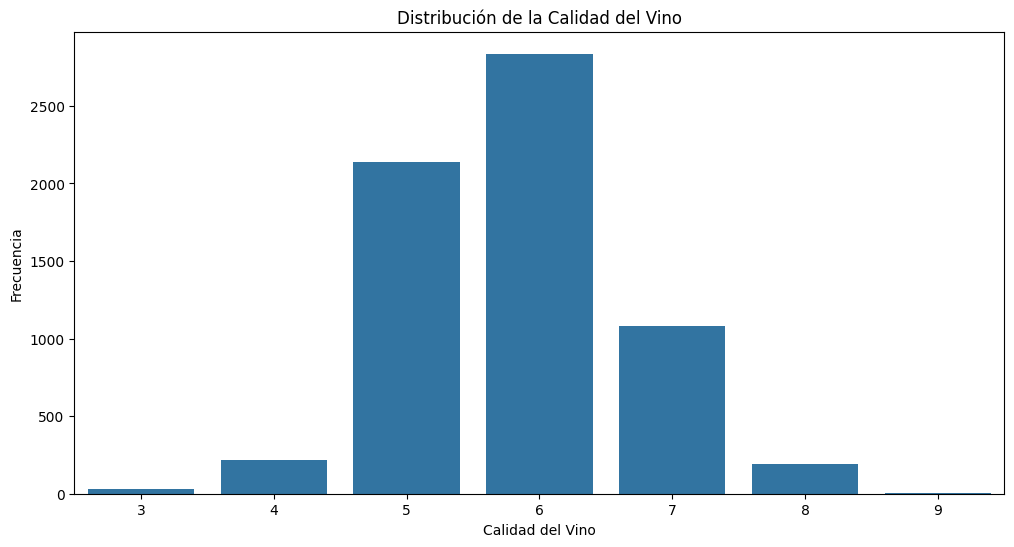

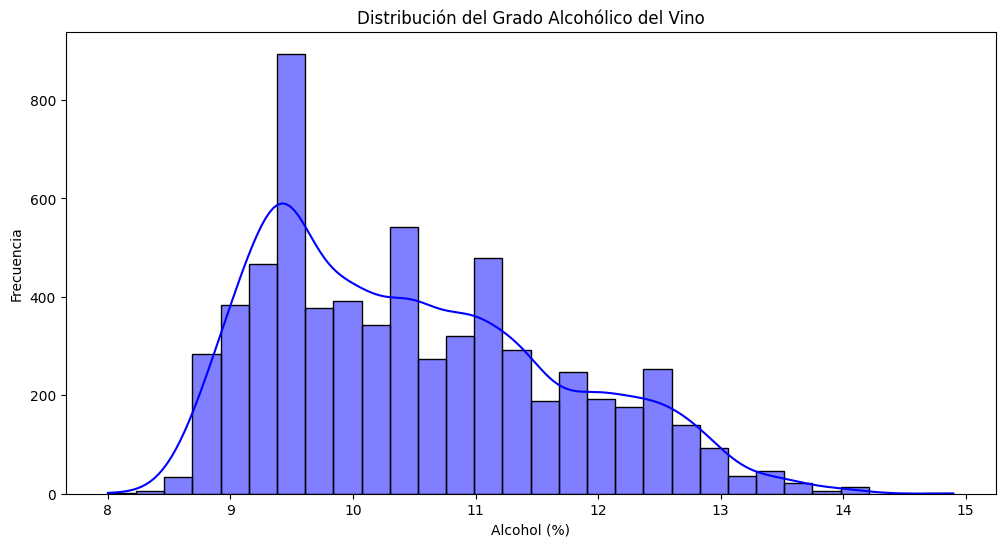

Recall medio para el problema de clasificación: 0.4497
Error absoluto medio (MAE) para el grado alcohólico: 0.2708
Error cuadrático medio (MSE) para el grado alcohólico: 0.1704


In [32]:
# Distribución del target (Calidad)
plt.figure(figsize=(12, 6))
sns.countplot(data=wines, x='quality')
plt.title('Distribución de la Calidad del Vino')
plt.xlabel('Calidad del Vino')
plt.ylabel('Frecuencia')
plt.show()

# Distribución del target (Alcohol)
plt.figure(figsize=(12, 6))
sns.histplot(wines['alcohol'], kde=True, color='blue', bins=30)
plt.title('Distribución del Grado Alcohólico del Vino')
plt.xlabel('Alcohol (%)')
plt.ylabel('Frecuencia')
plt.show()

# **Análisis de los problemas:**
# Primero, definimos las variables objetivo y características para los dos problemas

# **Problema 1: Clasificación de calidad**
X_class = wines.drop(columns=['quality', 'class'])
y_class = wines['quality']

# Dividir los datos en entrenamiento y prueba
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# **Problema 2: Predicción de grado alcohólico**
X_reg = wines.drop(columns=['alcohol', 'class', 'quality'])
y_reg = wines['alcohol']

# Dividir los datos en entrenamiento y prueba
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# **Evaluación del primer problema: Clasificación de calidad con recall medio**
# Utilizamos un modelo simple (por ejemplo, RandomForestClassifier) para hacer un test rápido
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
model_class = RandomForestClassifier(random_state=42)
model_class.fit(X_train_class, y_train_class)

# Predicciones
y_pred_class = model_class.predict(X_test_class)

# Calcular el recall medio
recall = recall_score(y_test_class, y_pred_class, average='macro')
print(f"Recall medio para el problema de clasificación: {recall:.4f}")

# **Evaluación del segundo problema: Predicción del grado alcohólico**
# Utilizamos un modelo simple (por ejemplo, RandomForestRegressor) para hacer un test rápido
from sklearn.ensemble import RandomForestRegressor
model_reg = RandomForestRegressor(random_state=42)
model_reg.fit(X_train_reg, y_train_reg)

# Predicciones
y_pred_reg = model_reg.predict(X_test_reg)

# Calcular el error absoluto medio y el error cuadrático medio
mae = mean_absolute_error(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)

print(f"Error absoluto medio (MAE) para el grado alcohólico: {mae:.4f}")
print(f"Error cuadrático medio (MSE) para el grado alcohólico: {mse:.4f}")


### #2 Modelado para clasificación

Crea un modelo que permita clasificar lo mejor posible los vinos en función de su calidad, o dicho de otro modo que prediga de la mejor manera posible la calidad de un vino a partir de sus propiedades químicas. ***Considéralo un problema de clasificación***, donde los valores de calidad son las clases a predecir. Puedes utilizar los modelos que creas conveniente, al menos tres, y utiliza un KNN como modelo baseline, prueba al menos con 2 valores de K. Intenta mejorar el "recall medio" con las técnicas que creas conveniente. Compara los modelos utilizando validación cruzada con o sin optimización previa de hiperparámetros (aunque en la sesión en vivo por limitación de tiempos sólo lo haremos con validación cruzada). El modelo elegido si tiene que tener un ejemplo de optimización de parámetros.

Evalúa el modelo, analiza los errores y propón algún mecanismo de mejora aunque sea sólo un esbozo.

Distribución de clases en los datos:
Counter({6: 2836, 5: 2138, 7: 1079, 4: 216, 8: 193, 3: 30, 9: 5})
Evaluando: KNN (K=3)
Recall medio para KNN (K=3): 0.2945 ± 0.0122

Evaluando: KNN (K=5)
Recall medio para KNN (K=5): 0.2743 ± 0.0129

Evaluando: Random Forest
Recall medio para Random Forest: 0.3679 ± 0.0054

Evaluando: Logistic Regression
Recall medio para Logistic Regression: 0.3838 ± 0.0577



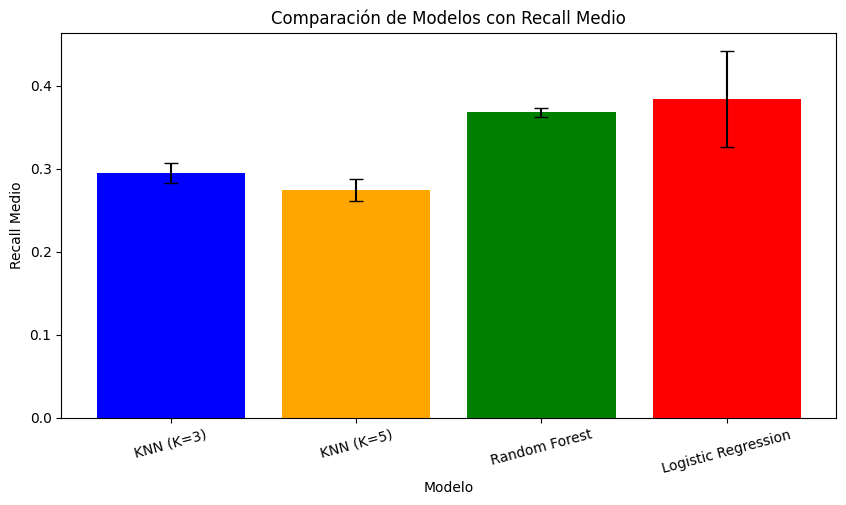

El mejor modelo es: Logistic Regression con un Recall Medio de 0.3838

Reporte de clasificación:
              precision    recall  f1-score   support

           3       0.01      0.33      0.03         6
           4       0.08      0.42      0.14        43
           5       0.57      0.36      0.44       428
           6       0.62      0.24      0.34       567
           7       0.35      0.31      0.32       216
           8       0.06      0.33      0.10        39
           9       0.04      1.00      0.07         1

    accuracy                           0.30      1300
   macro avg       0.25      0.43      0.21      1300
weighted avg       0.52      0.30      0.36      1300


Etiquetas presentes en los datos:
Reales: {3, 4, 5, 6, 7, 8, 9}
Predichas: {3, 4, 5, 6, 7, 8, 9}


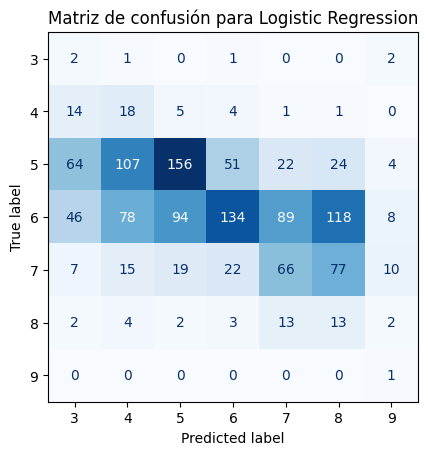

In [34]:


# Preprocesamiento de datos
X = wines.drop(columns=['quality', 'class'])  # Eliminamos también 'class' para centrarnos en calidad
y = wines['quality']

# Análisis del balance de clases
print("Distribución de clases en los datos:")
print(Counter(y))

# Modelos de clasificación con ajustes
models = {
    'KNN (K=3)': KNeighborsClassifier(n_neighbors=3),
    'KNN (K=5)': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
}

# Validación cruzada con estratificación
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluación de modelos
results = {}
for model_name, model in models.items():
    print(f"Evaluando: {model_name}")
    
    # Crear pipeline para combinar escalado y modelo
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Validación cruzada con recall_macro
    recall_scores = cross_val_score(pipeline, X, y, cv=skf, scoring='recall_macro')
    results[model_name] = recall_scores
    print(f"Recall medio para {model_name}: {recall_scores.mean():.4f} ± {recall_scores.std():.4f}\n")

# Visualización de resultados
plt.figure(figsize=(10, 5))
means = [scores.mean() for scores in results.values()]
stds = [scores.std() for scores in results.values()]
plt.bar(results.keys(), means, yerr=stds, capsize=5, color=['blue', 'orange', 'green', 'red'])
plt.title('Comparación de Modelos con Recall Medio')
plt.ylabel('Recall Medio')
plt.xlabel('Modelo')
plt.xticks(rotation=15)
plt.show()

# Elegir el mejor modelo basado en recall medio
best_model_name = max(results, key=lambda x: results[x].mean())
print(f"El mejor modelo es: {best_model_name} con un Recall Medio de {results[best_model_name].mean():.4f}")

# Evaluación del mejor modelo en el conjunto de prueba
final_model = models[best_model_name]
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', final_model)
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Reporte de clasificación y matriz de confusión
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, zero_division=0))  # Evitar advertencias de métricas no definidas

# Verificar etiquetas reales y predichas
print("\nEtiquetas presentes en los datos:")
print(f"Reales: {set(y_test)}")
print(f"Predichas: {set(y_pred)}")

# Visualizar la matriz de confusión
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, cmap='Blues', colorbar=False)
plt.title(f"Matriz de confusión para {best_model_name}")
plt.show()


Distribución de clases antes de SMOTE:
Counter({6: 2836, 5: 2138, 7: 1079, 4: 216, 8: 193, 3: 30, 9: 5})
Usando k_neighbors=3 en SMOTE.

Distribución de clases después de SMOTE:
Counter({5: 2269, 7: 2269, 6: 2269, 8: 2269, 3: 2269, 4: 2269, 9: 2269})
Evaluando: KNN (K=3)
Recall medio para KNN (K=3): 0.8287 ± 0.0030

Evaluando: Random Forest
Recall medio para Random Forest: 0.8847 ± 0.0036

Evaluando: Logistic Regression
Recall medio para Logistic Regression: 0.5357 ± 0.0087



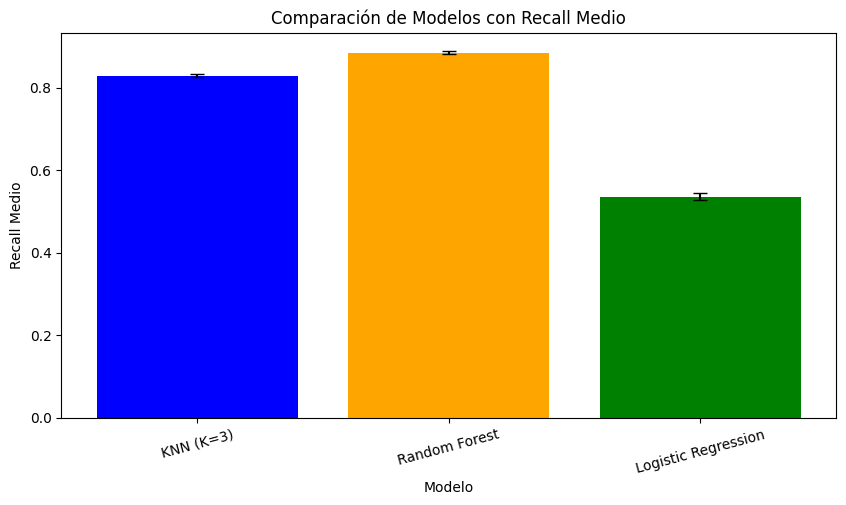

El mejor modelo es: Random Forest con un Recall Medio de 0.8847

Reporte de clasificación:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.21      0.28      0.24        43
           5       0.72      0.71      0.71       428
           6       0.70      0.64      0.67       567
           7       0.55      0.60      0.57       216
           8       0.26      0.36      0.30        39
           9       0.00      0.00      0.00         1

    accuracy                           0.63      1300
   macro avg       0.35      0.37      0.36      1300
weighted avg       0.65      0.63      0.64      1300



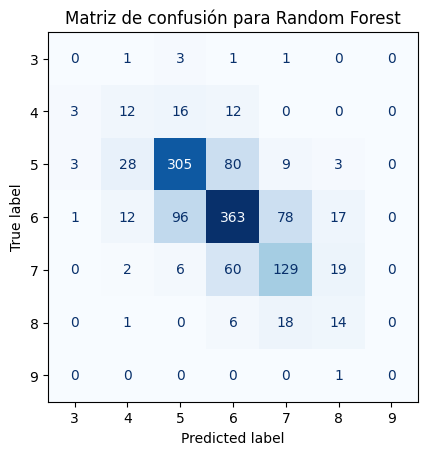

In [35]:
# Preprocesamiento de datos
X = wines.drop(columns=['quality', 'class'])  # Eliminamos también 'class' para centrarnos en calidad
y = wines['quality']

# Análisis del balance de clases antes del sobremuestreo
print("Distribución de clases antes de SMOTE:")
print(Counter(y))

# Dividir los datos antes de aplicar SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Ajustar dinámicamente el parámetro k_neighbors de SMOTE
min_class_size = min(Counter(y_train).values())
smote_k_neighbors = min(5, min_class_size - 1) if min_class_size > 1 else 1
print(f"Usando k_neighbors={smote_k_neighbors} en SMOTE.")

# Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42, k_neighbors=smote_k_neighbors)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Análisis del balance de clases después de SMOTE
print("\nDistribución de clases después de SMOTE:")
print(Counter(y_train_resampled))

# Ajustar dinámicamente el parámetro n_neighbors de KNN
knn_neighbors = min(3, min(Counter(y_train_resampled).values()))

# Modelos de clasificación con ajustes
models = {
    f'KNN (K={knn_neighbors})': KNeighborsClassifier(n_neighbors=knn_neighbors),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Validación cruzada con estratificación
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluación de modelos
results = {}
for model_name, model in models.items():
    print(f"Evaluando: {model_name}")
    
    # Crear pipeline para combinar escalado y modelo
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Validación cruzada con recall_macro (usando datos sobremuestreados)
    recall_scores = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=skf, scoring='recall_macro')
    results[model_name] = recall_scores
    print(f"Recall medio para {model_name}: {recall_scores.mean():.4f} ± {recall_scores.std():.4f}\n")

# Visualización de resultados
plt.figure(figsize=(10, 5))
means = [scores.mean() for scores in results.values()]
stds = [scores.std() for scores in results.values()]
plt.bar(results.keys(), means, yerr=stds, capsize=5, color=['blue', 'orange', 'green'])
plt.title('Comparación de Modelos con Recall Medio')
plt.ylabel('Recall Medio')
plt.xlabel('Modelo')
plt.xticks(rotation=15)
plt.show()

# Elegir el mejor modelo basado en recall medio
best_model_name = max(results, key=lambda x: results[x].mean())
print(f"El mejor modelo es: {best_model_name} con un Recall Medio de {results[best_model_name].mean():.4f}")

# Evaluación del mejor modelo en el conjunto de prueba
final_model = models[best_model_name]
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', final_model)
])
pipeline.fit(X_train_resampled, y_train_resampled)
y_pred = pipeline.predict(X_test)

# Reporte de clasificación y matriz de confusión
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, zero_division=0))

# Visualizar la matriz de confusión
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, cmap='Blues', colorbar=False)
plt.title(f"Matriz de confusión para {best_model_name}")
plt.show()


### #3 Modelado para regresión

Reutiliza todo lo que puedas la preparación del modelado de la parte anterior y construye ahora el mejor modelo que puedas para predecir el grado alcohólico de un vino dadas sus características fisico químicas, su clase y la puntuación de calidad que le ha sido otorgada. Compara al menos tres tipos de modelos, seleccionando una métrica adecuada de comparación y escoge el más apropiado empleando validación cruzada antes o después de optimizar hiperparámetros (en la sesión en vivo lo haremos antes por cuestiones de tiempo). Evalúa el modelo escogido y con los hiperparámetros ajustados de la mejor manera que puedas. Para terminar realizar un pequeño análisis de errores.

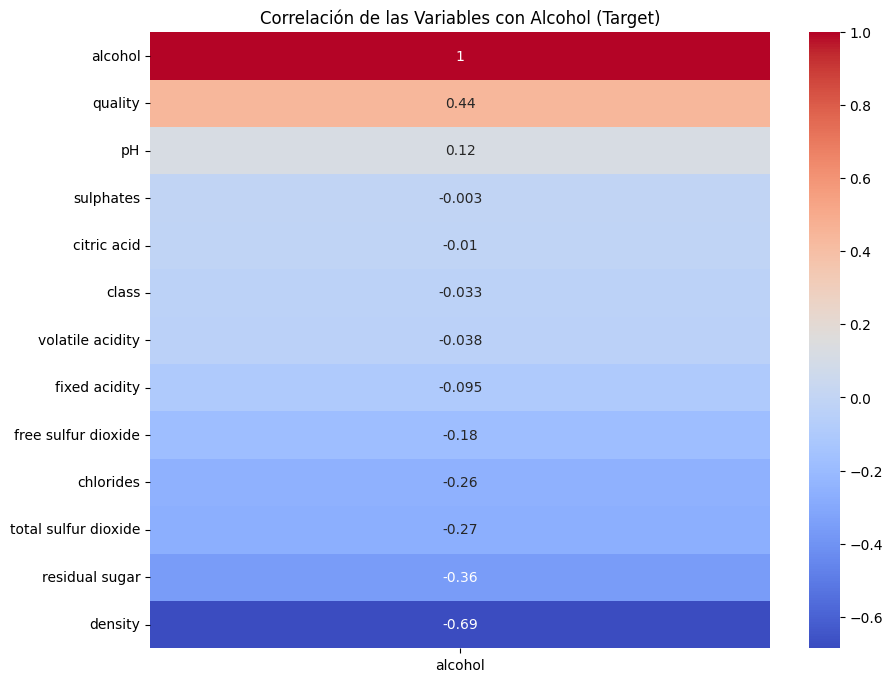

Evaluando: Regresión Lineal
MAE para Regresión Lineal: 0.3973 ± 0.0091

Evaluando: Random Forest
MAE para Random Forest: 0.2622 ± 0.0067



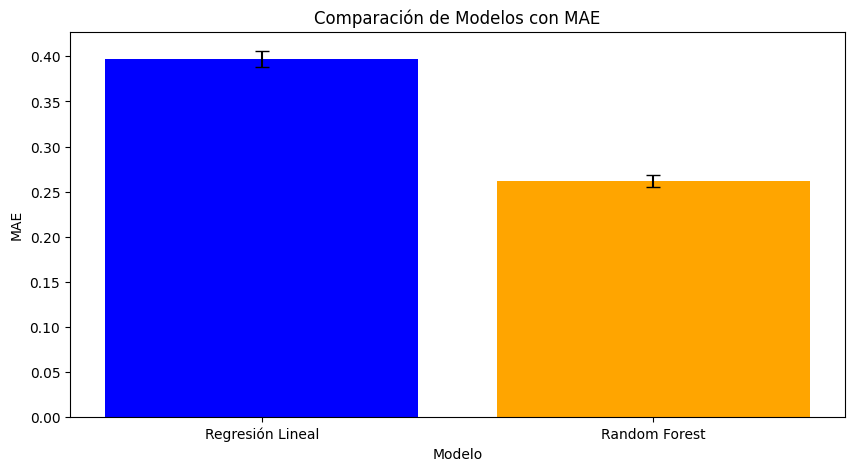

El mejor modelo es: Random Forest con un MAE de 0.2622
Mejores hiperparámetros: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}

Evaluación del modelo final:
MAE: 0.2689
MAPE: 0.0254
R²: 0.8811


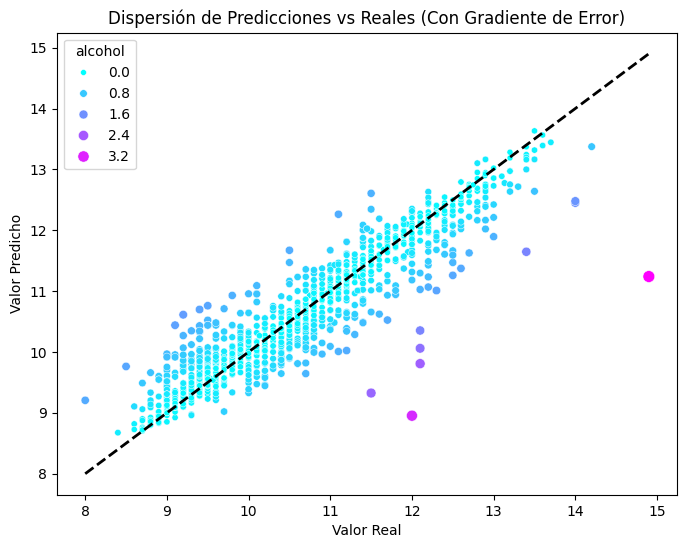

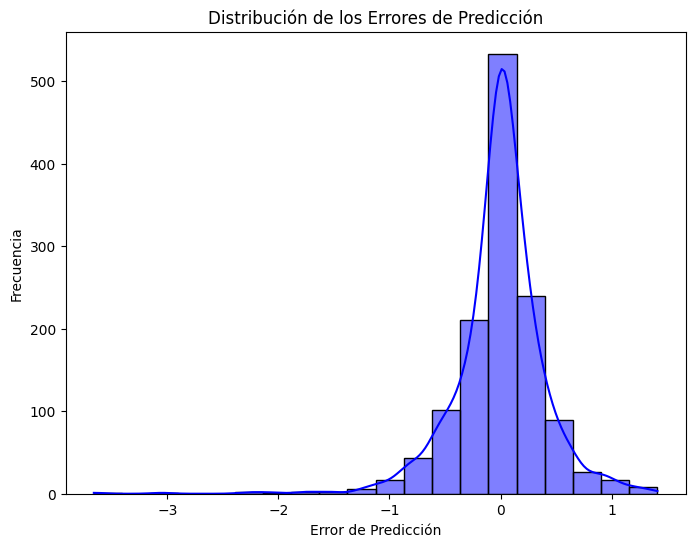

In [37]:


# Análisis preliminar: Correlación con el target
correlation_matrix = wines.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['alcohol']].sort_values(by='alcohol', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlación de las Variables con Alcohol (Target)')
plt.show()

# Preprocesamiento
X = wines.drop(columns=['quality', 'class', 'alcohol'])
y = wines['alcohol']

# Modelos de regresión
models = {
    'Regresión Lineal': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42)
}

# Validación cruzada con MAE
results = {}
for model_name, model in models.items():
    print(f"Evaluando: {model_name}")
    
    # Usar pipeline para combinar escalado y modelo
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    mae_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
    results[model_name] = {
        'mean_mae': -mae_scores.mean(),  # Convertimos a positivo
        'std_mae': mae_scores.std()
    }
    print(f"MAE para {model_name}: {results[model_name]['mean_mae']:.4f} ± {results[model_name]['std_mae']:.4f}\n")

# Visualización de los resultados con barras de error
plt.figure(figsize=(10, 5))
means = [res['mean_mae'] for res in results.values()]
stds = [res['std_mae'] for res in results.values()]
plt.bar(results.keys(), means, yerr=stds, capsize=5, color=['blue', 'orange'])
plt.title('Comparación de Modelos con MAE')
plt.ylabel('MAE')
plt.xlabel('Modelo')
plt.show()

# Tuning de hiperparámetros para el mejor modelo
best_model_name = min(results, key=lambda x: results[x]['mean_mae'])
print(f"El mejor modelo es: {best_model_name} con un MAE de {results[best_model_name]['mean_mae']:.4f}")

if best_model_name == 'Random Forest':
    param_grid = {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10]
    }
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(random_state=42))
    ])
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X, y)
    final_model = grid_search.best_estimator_
    print("Mejores hiperparámetros:", grid_search.best_params_)
else:
    final_model = models[best_model_name]

# Evaluar el modelo final
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nEvaluación del modelo final:")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R²: {r2:.4f}")

# Gráfico de dispersión mejorado
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, hue=np.abs(y_pred - y_test), palette='cool', size=np.abs(y_pred - y_test))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.title('Dispersión de Predicciones vs Reales (Con Gradiente de Error)')
plt.show()

# Distribución de errores
errors = y_pred - y_test
plt.figure(figsize=(8, 6))
sns.histplot(errors, kde=True, color='blue', bins=20)
plt.title('Distribución de los Errores de Predicción')
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')
plt.show()
